In [1]:
import pandas as pd
df = (
    pd.read_csv("df_clean.csv", index_col = 0)
    .assign(action_token = lambda d: pd.Categorical(d.action_token))
)

vocab = df['action_token'].cat.categories

df

match_id        action_token dataset
0            315       True,pass,4,4   train
1            315   True,receival,4,5   train
2            315    True,dribble,4,5   train
3            315       True,pass,5,5   train
4            315   True,receival,6,4   train
...          ...                 ...     ...
939915        82  False,receival,8,0    test
939916        82   False,dribble,8,0    test
939917        82     True,tackle,9,0    test
939918        82    True,dribble,9,0    test
939919        82       True,pass,8,1    test

[939920 rows x 3 columns]

In [2]:
import torch
from models.transformer import BasicTransformer

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = BasicTransformer(len(vocab), 50, 2, 500, 1, 0.0).to(device=device)
model.load_state_dict(torch.load("model_weights_v3.pt", map_location=torch.device('cpu')))
model.eval()

BasicTransformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
        )
        (linear1): Linear(in_features=50, out_features=500, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=500, out_features=50, bias=True)
        (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Linear(in_features=50, out_features=3015, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (input_emb): Embedding(3015, 50)
)

In [3]:
embeddings = model.input_emb.weight.data.numpy()
embeddings.shape

(3015, 50)

In [82]:
from plotnine import *
import numpy as np

In [48]:
action_type_counts = (
    df
    .assign(
        action_type = lambda d: d.action_token.str.split(',').str[1],
    )
    ['action_type']
    .value_counts(normalize = True)
)

action_type_counts

action_type
pass            0.272368
dribble         0.270853
receival        0.244303
interception    0.071158
throw_in        0.020061
out             0.018759
clearance       0.018302
tackle          0.014143
take_on         0.012583
bad_touch       0.011485
shot            0.008489
freekick        0.007496
foul            0.006981
cross           0.006872
goalkick        0.006093
corner          0.003203
keeper_save     0.002126
keeper_claim    0.001287
offside         0.001247
goal            0.001023
yellow_card     0.000634
keeper_punch    0.000400
shot_penalty    0.000087
owngoal         0.000039
red_card        0.000006
Name: proportion, dtype: float64

In [54]:
threshold = 0.2

action_type_counts = (
    df
    .assign(
        action_type = lambda d: d.action_token.str.split(',').str[1],
    )
    ['action_type']
    .value_counts(normalize = True)
)

actions_to_replace = action_type_counts[action_type_counts < threshold].index

## UMAP Plots

In [99]:
# !pip install umap-learn
import umap.umap_ as umap

umap_reducer = umap.UMAP(random_state=42)

umap_embeddings_df = (
    pd.DataFrame(umap_reducer.fit_transform(embeddings), columns = ["dim_1", "dim_2"])
    .assign(
        token = vocab,
        team = lambda d: d.token.str.split(',').str[0],
        action_type = lambda d: d.token.str.split(',').str[1],
        action_type_clean = lambda d: d.action_type.replace({a: 'other' for a in actions_to_replace}),
        x_bin = lambda d: d.token.str.split(',').str[2].astype(int),
        y_bin = lambda d: d.token.str.split(',').str[3].astype(int)
    )
)

umap_embeddings_df

c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


dim_1     dim_2                 token   team  action_type  \
0      9.157611  7.711020   False,bad_touch,0,0  False    bad_touch   
1      9.154250  7.611515   False,bad_touch,0,1  False    bad_touch   
2      9.778510  7.734587   False,bad_touch,0,2  False    bad_touch   
3      9.552289  7.442046   False,bad_touch,0,3  False    bad_touch   
4      9.719958  7.613819   False,bad_touch,0,4  False    bad_touch   
...         ...       ...                   ...    ...          ...   
3010  10.133119  8.060389  True,yellow_card,9,1   True  yellow_card   
3011   9.719445  8.220858  True,yellow_card,9,3   True  yellow_card   
3012  12.066552  8.380336  True,yellow_card,9,4   True  yellow_card   
3013  10.287173  8.269889  True,yellow_card,9,5   True  yellow_card   
3014  12.278069  7.781974  True,yellow_card,9,6   True  yellow_card   

     action_type_clean  x_bin  y_bin  
0                other      0      0  
1                other      0      1  
2                other      0      2  
3                other      0      3  
4                other      0      4  
...                ...    ...    ...  
3010             other      9      1  
3011             other      9      3  
3012             other      9      4  
3013             other      9      5  
3014             other      9      6  

[3015 rows x 8 columns]

c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: UMAP_viz_team.png


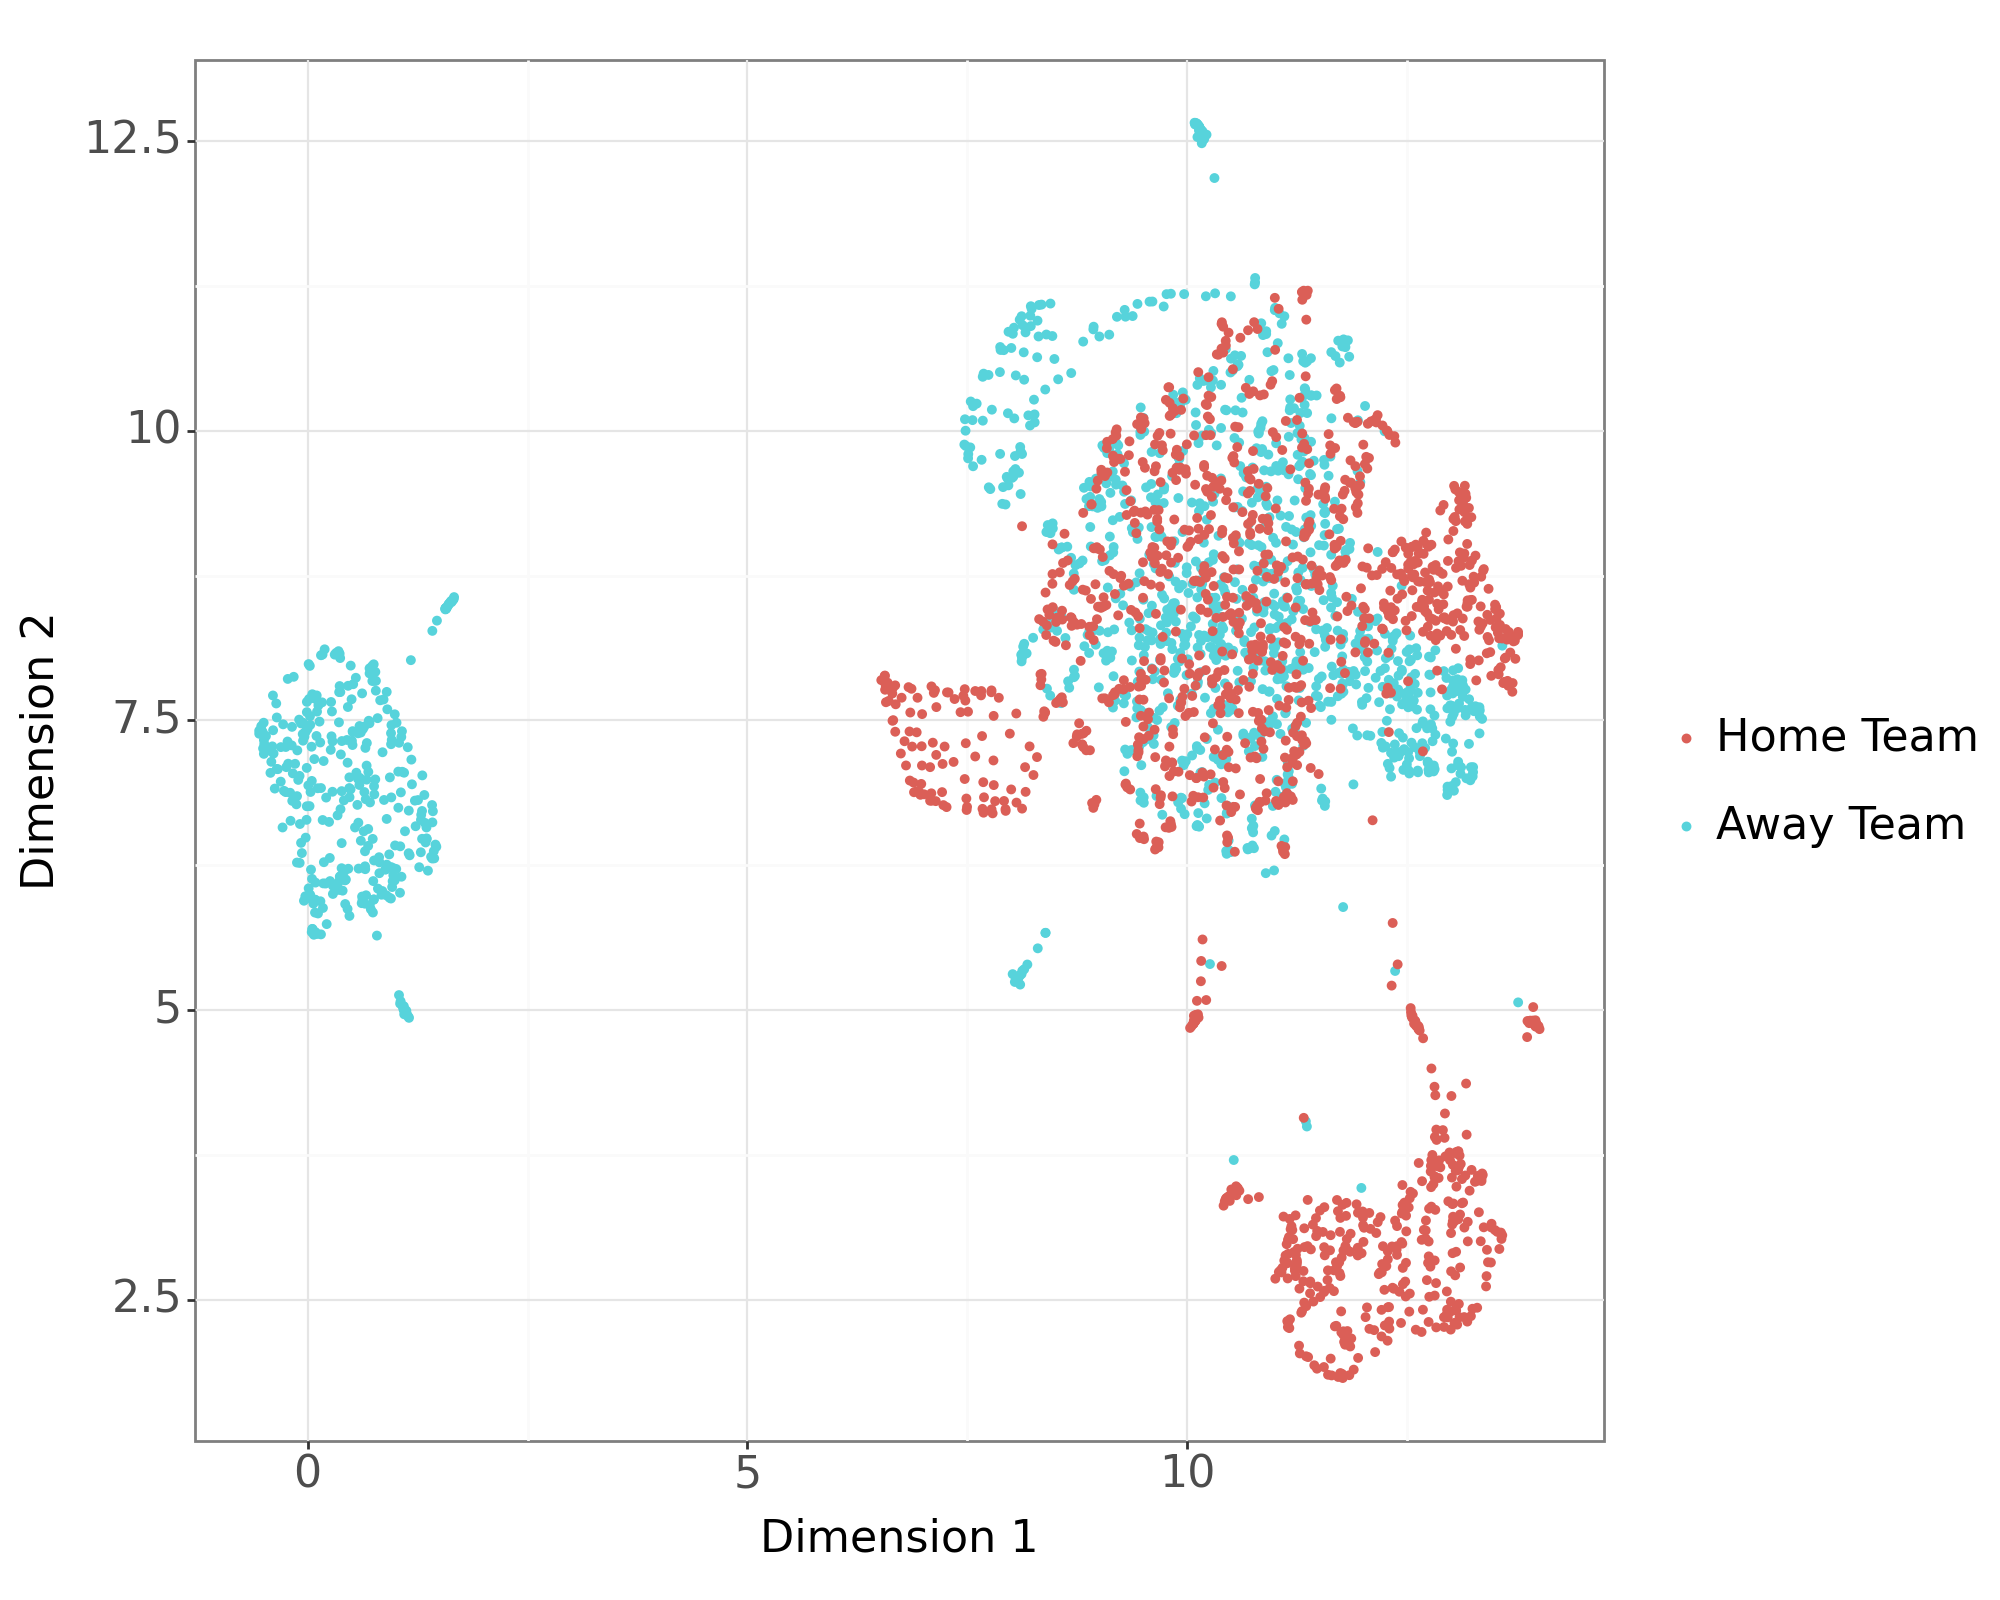

<Figure Size: (1000 x 800)>

In [111]:
p = (
    umap_embeddings_df
    .assign(Team = lambda d: pd.Categorical(np.where(d.team == "True", "Home Team", "Away Team"), categories = ["Home Team", "Away Team"]))
    .pipe(ggplot, aes(x = 'dim_1', y = 'dim_2', colour = 'Team')) +
    geom_point(size = 1) +
    theme_bw() +
    labs(x = "Dimension 1", y = "Dimension 2", colour = "") +
    theme(figure_size=(10, 8), text=element_text(size=16), legend_entry_spacing_y=16, legend_key=element_blank())
)

p.save("UMAP_viz_team.png")

p

c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: UMAP_viz_action_type.png


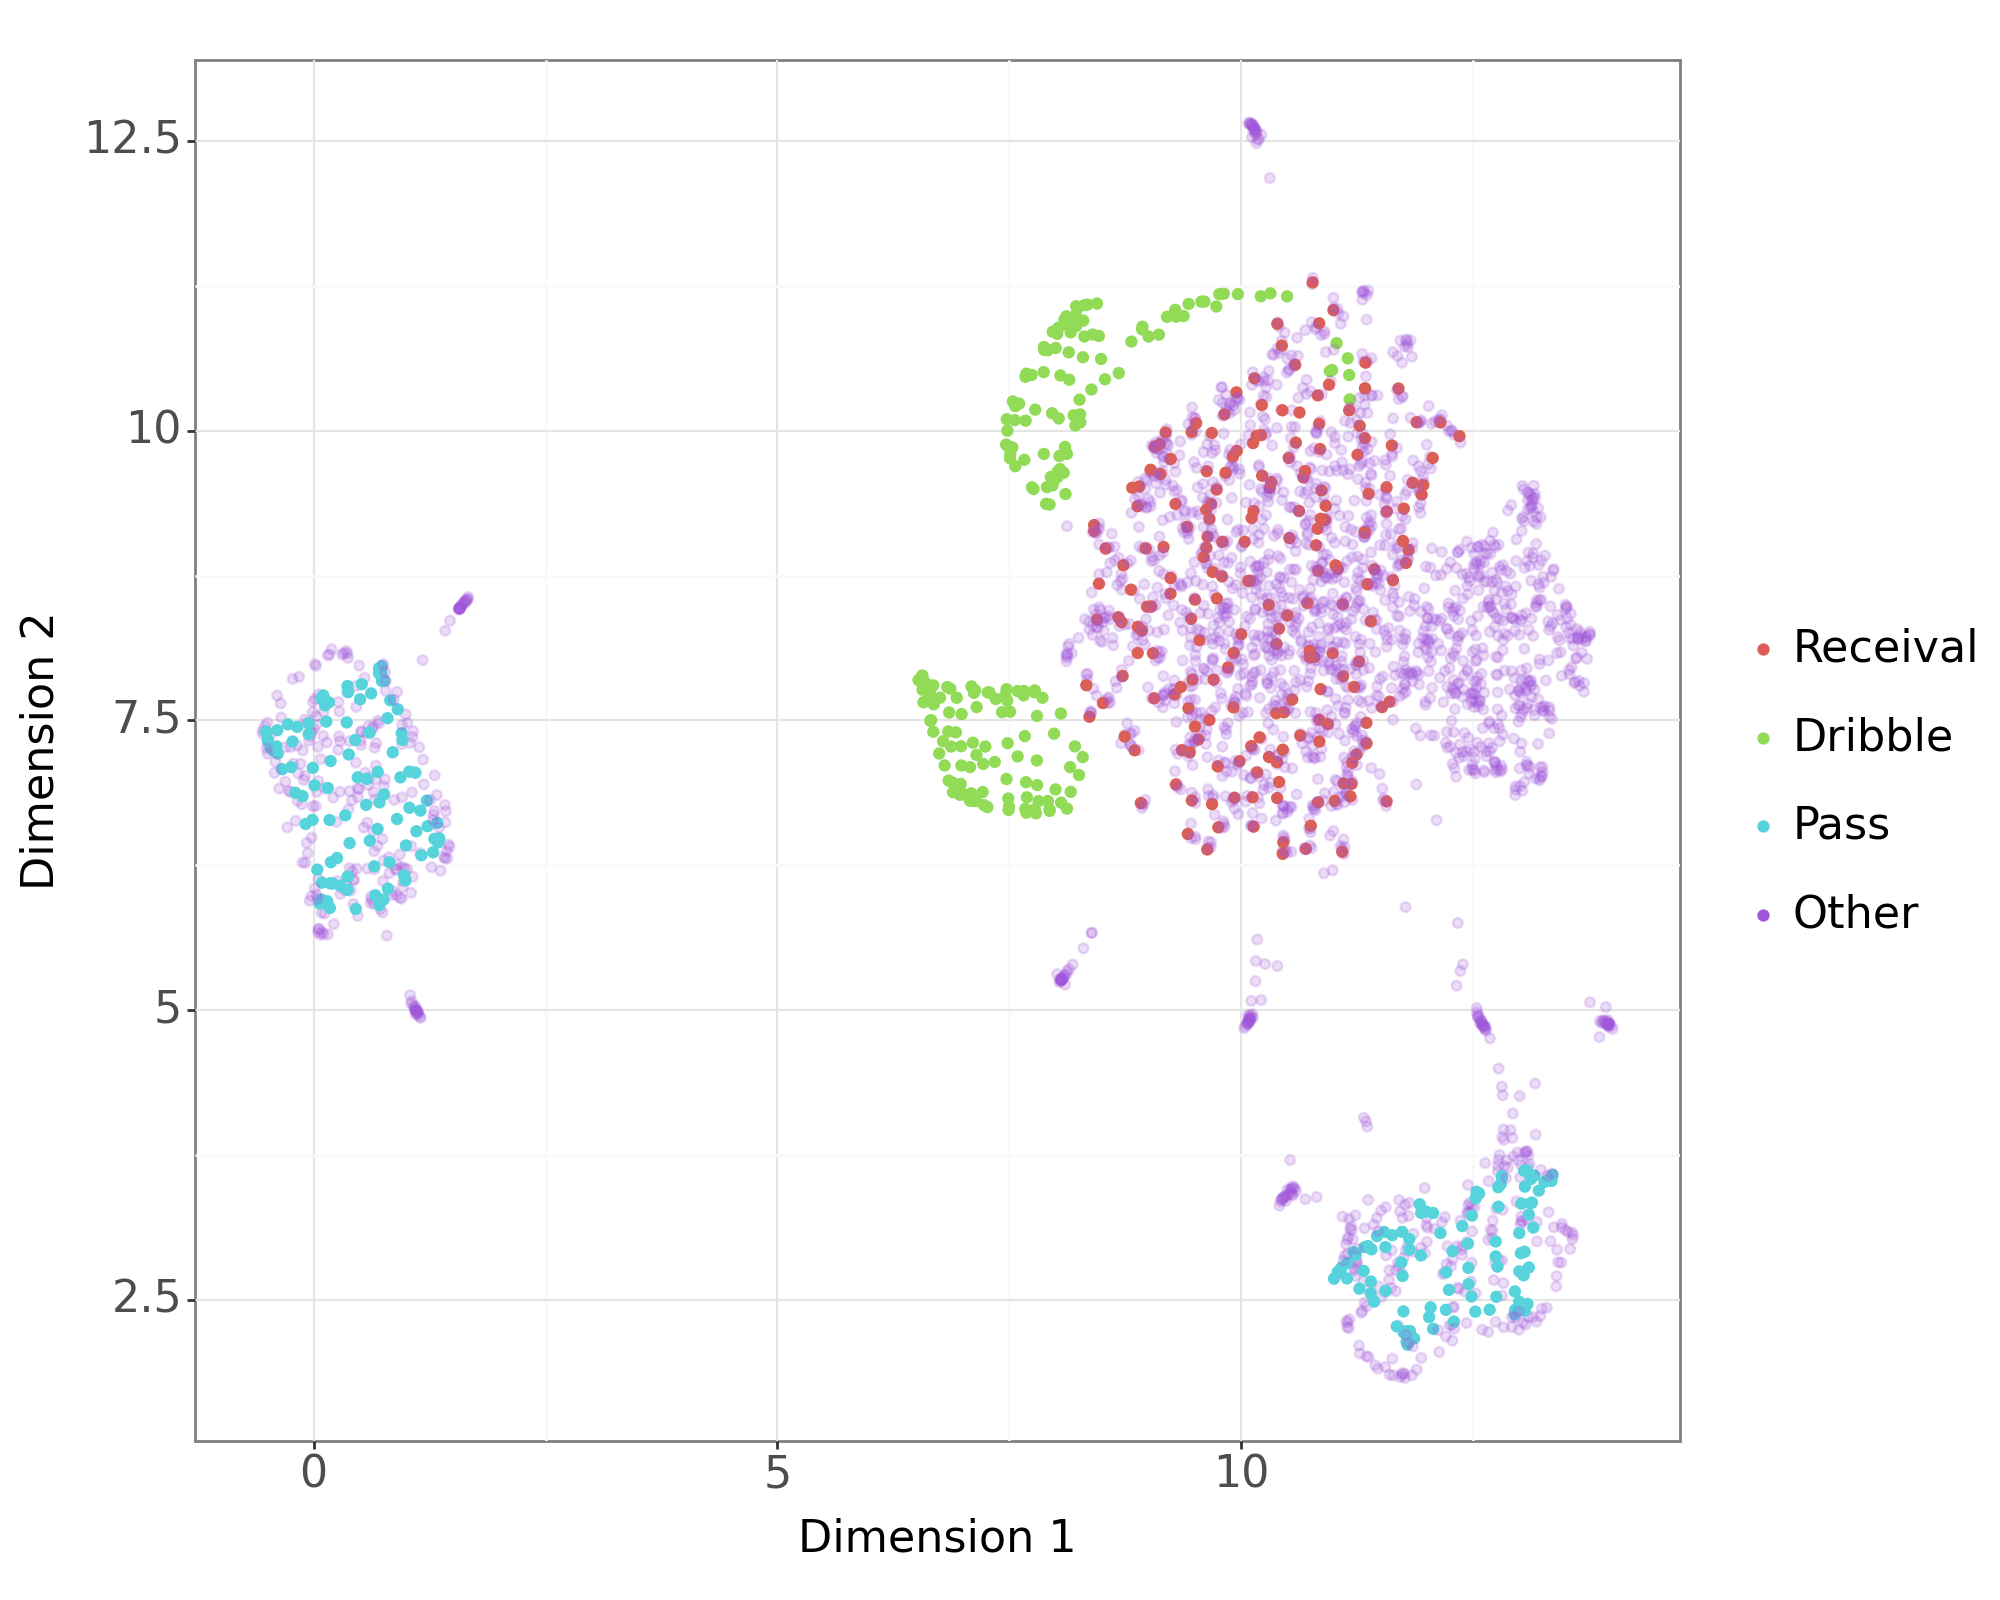

<Figure Size: (1000 x 800)>

In [112]:
p = (
    umap_embeddings_df
    .assign(action_type_clean = lambda d: pd.Categorical(d.action_type_clean.str.capitalize(), categories = ["Receival", "Dribble", "Pass", "Other"]))
    .pipe(ggplot, aes(x = 'dim_1', y = 'dim_2', colour = 'action_type_clean', alpha = 'action_type_clean')) +
    geom_point() +
    scale_alpha_manual([1, 1, 1, 0.2]) +
    guides(alpha = None) +
    theme_bw() +
    labs(x = "Dimension 1", y = "Dimension 2", colour = "") +
    theme(figure_size=(10, 8), text=element_text(size=16), legend_entry_spacing_y=16, legend_key=element_blank())
)

p.save("UMAP_viz_action_type.png")

p

c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: UMAP_viz_x_bin.png


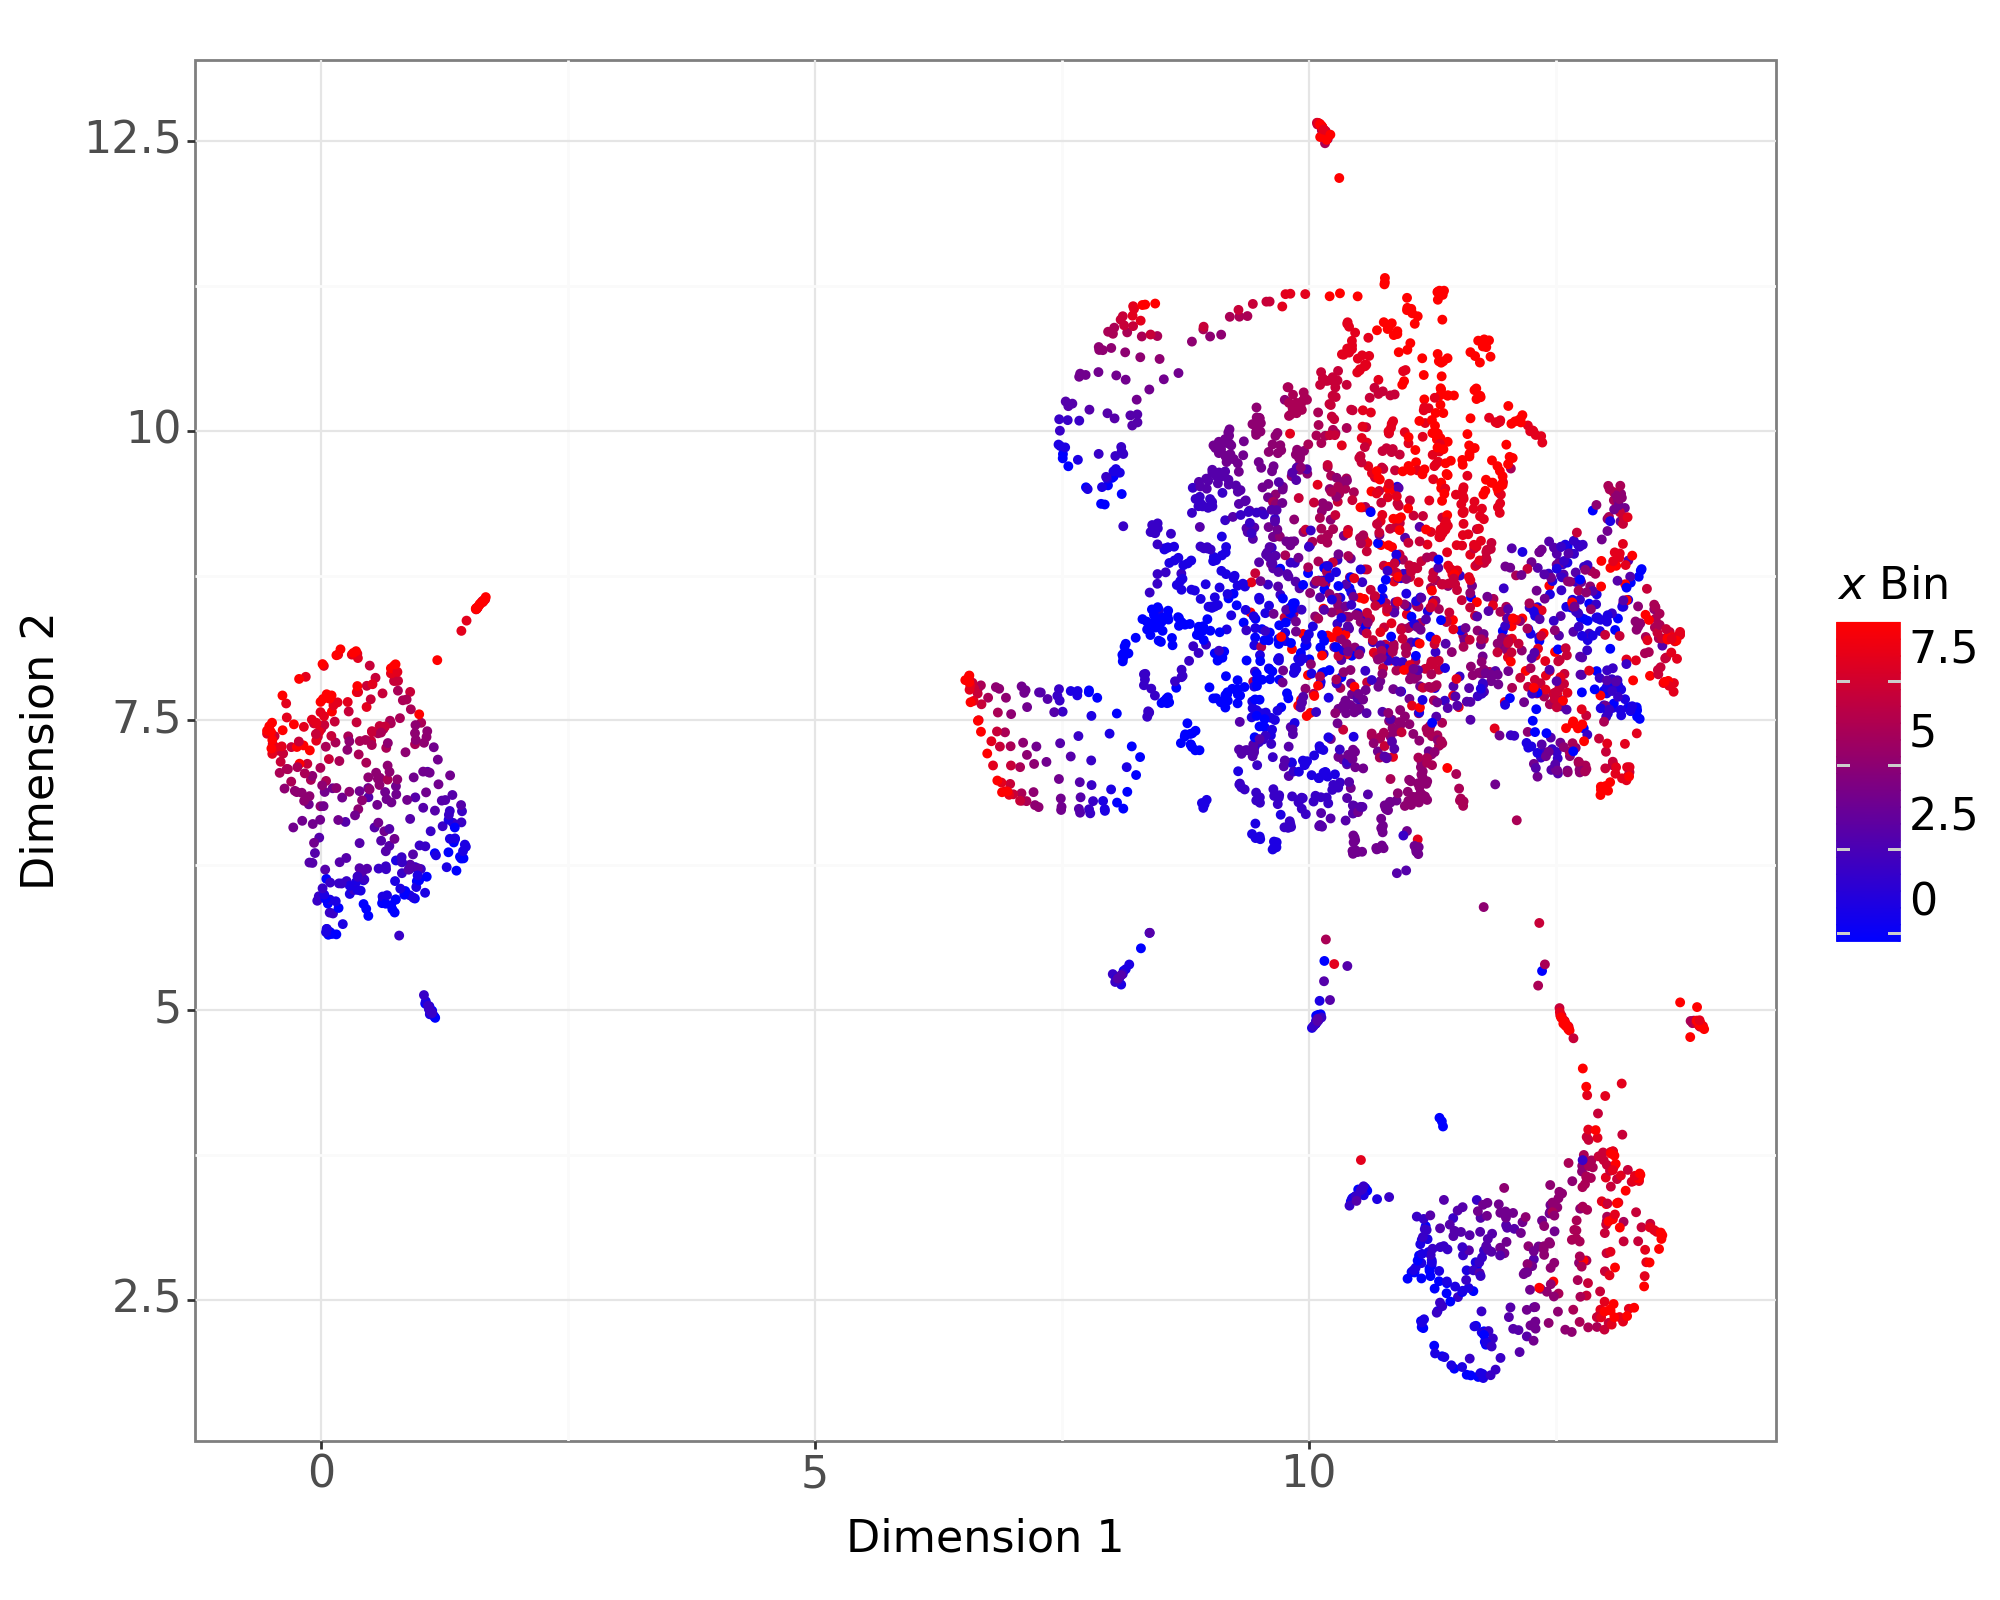

<Figure Size: (1000 x 800)>

In [113]:
p = (
    umap_embeddings_df
    .pipe(ggplot, aes(x = 'dim_1', y = 'dim_2', colour = 'x_bin')) +
    geom_point(size = 1) +
    theme_bw() +
    labs(x = "Dimension 1", y = "Dimension 2", color = "$x$ Bin") +
    theme(figure_size=(10, 8), text=element_text(size=16), legend_entry_spacing_y=16) +
    scale_color_gradient(low = "blue", high = "red")
)

p.save("UMAP_viz_x_bin.png")

p

c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: UMAP_viz_y_bin.png


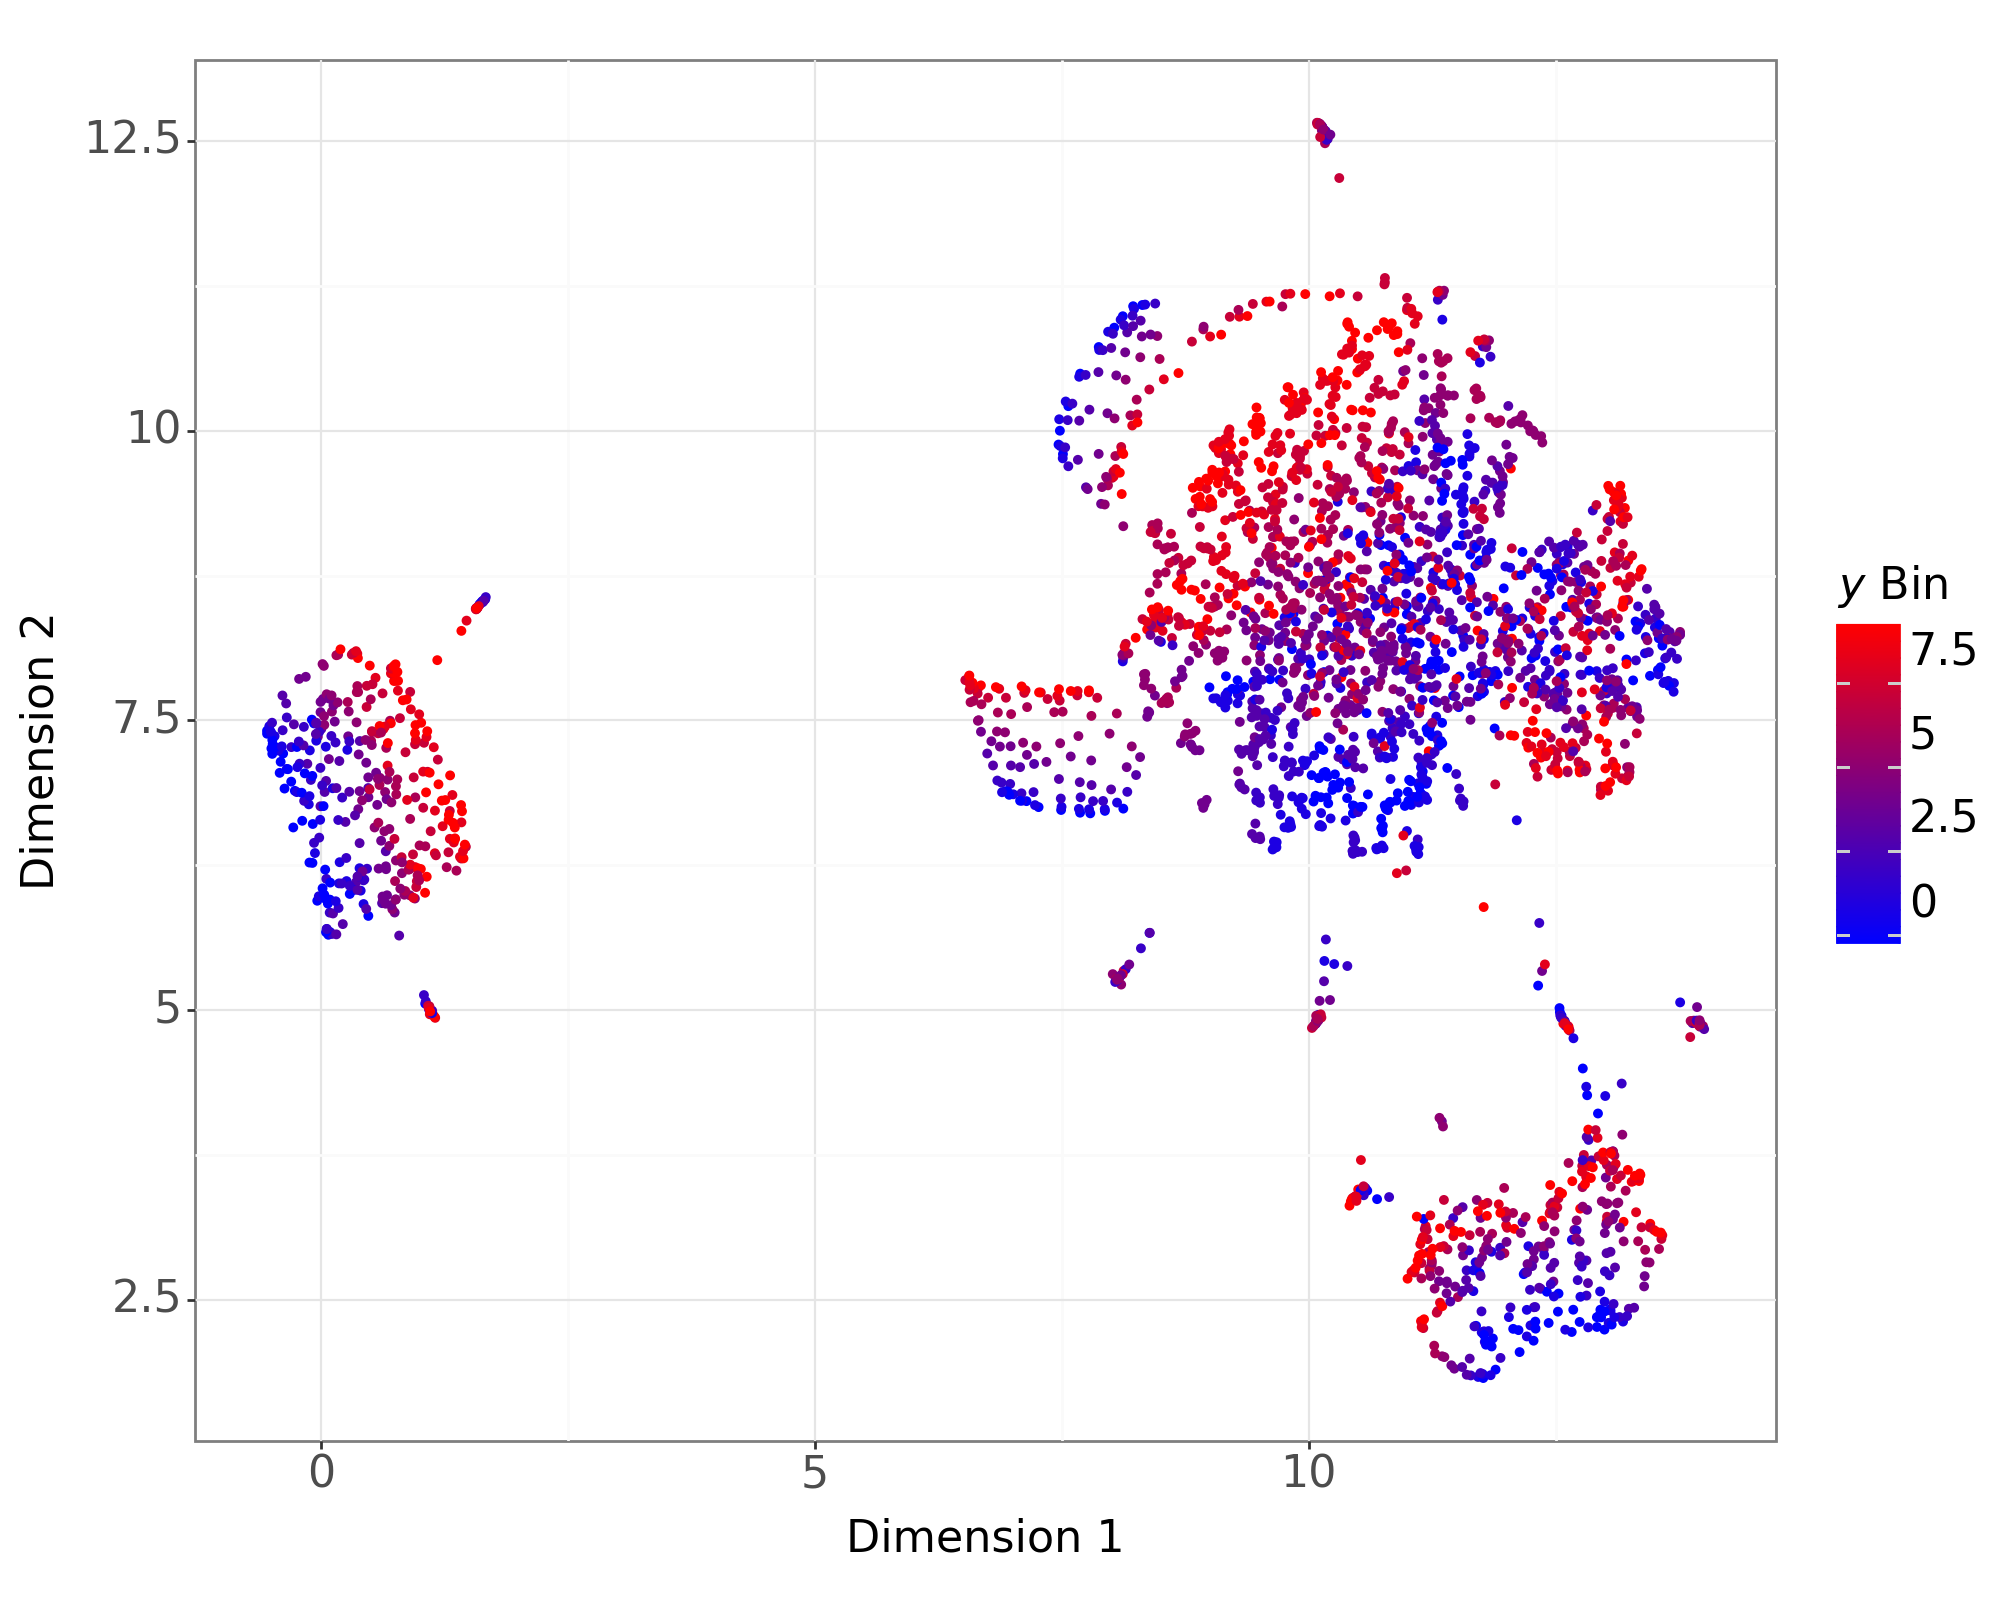

<Figure Size: (1000 x 800)>

In [114]:
p = (
    umap_embeddings_df
    .pipe(ggplot, aes(x = 'dim_1', y = 'dim_2', colour = 'y_bin')) +
    geom_point(size = 1) +
    theme_bw() +
    labs(x = "Dimension 1", y = "Dimension 2", color = "$y$ Bin") +
    theme(figure_size=(10, 8), text=element_text(size=16), legend_entry_spacing_y=16) +
    scale_color_gradient(low = "blue", high = "red")
)

p.save("UMAP_viz_y_bin.png")

p

## T-SNE Plots

In [10]:
from sklearn.manifold import TSNE

tsne_reducer = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, random_state=42)

tsne_embeddings_df = (
    pd.DataFrame(tsne_reducer.fit_transform(embeddings), columns = ["dim_1", "dim_2"])
    .assign(
        token = vocab,
        team = lambda d: d.token.str.split(',').str[0],
        action_type = lambda d: d.token.str.split(',').str[1],
        x_bin = lambda d: d.token.str.split(',').str[2],
        y_bin = lambda d: d.token.str.split(',').str[3]
    )
)

tsne_embeddings_df

dim_1      dim_2                 token   team  action_type x_bin  \
0    -28.233013 -59.867706   False,bad_touch,0,0  False    bad_touch     0   
1    -27.514643 -61.052650   False,bad_touch,0,1  False    bad_touch     0   
2     10.241644  -2.741055   False,bad_touch,0,2  False    bad_touch     0   
3     20.263031 -21.743298   False,bad_touch,0,3  False    bad_touch     0   
4    -35.523636  -2.122960   False,bad_touch,0,4  False    bad_touch     0   
...         ...        ...                   ...    ...          ...   ...   
3010  -5.733250  -9.047626  True,yellow_card,9,1   True  yellow_card     9   
3011 -11.004039  -6.322733  True,yellow_card,9,3   True  yellow_card     9   
3012  -6.253769   2.208038  True,yellow_card,9,4   True  yellow_card     9   
3013 -15.341250 -12.075807  True,yellow_card,9,5   True  yellow_card     9   
3014  14.288300  31.926708  True,yellow_card,9,6   True  yellow_card     9   

     y_bin  
0        0  
1        1  
2        2  
3        3  
4        4  
...    ...  
3010     1  
3011     3  
3012     4  
3013     5  
3014     6  

[3015 rows x 7 columns]

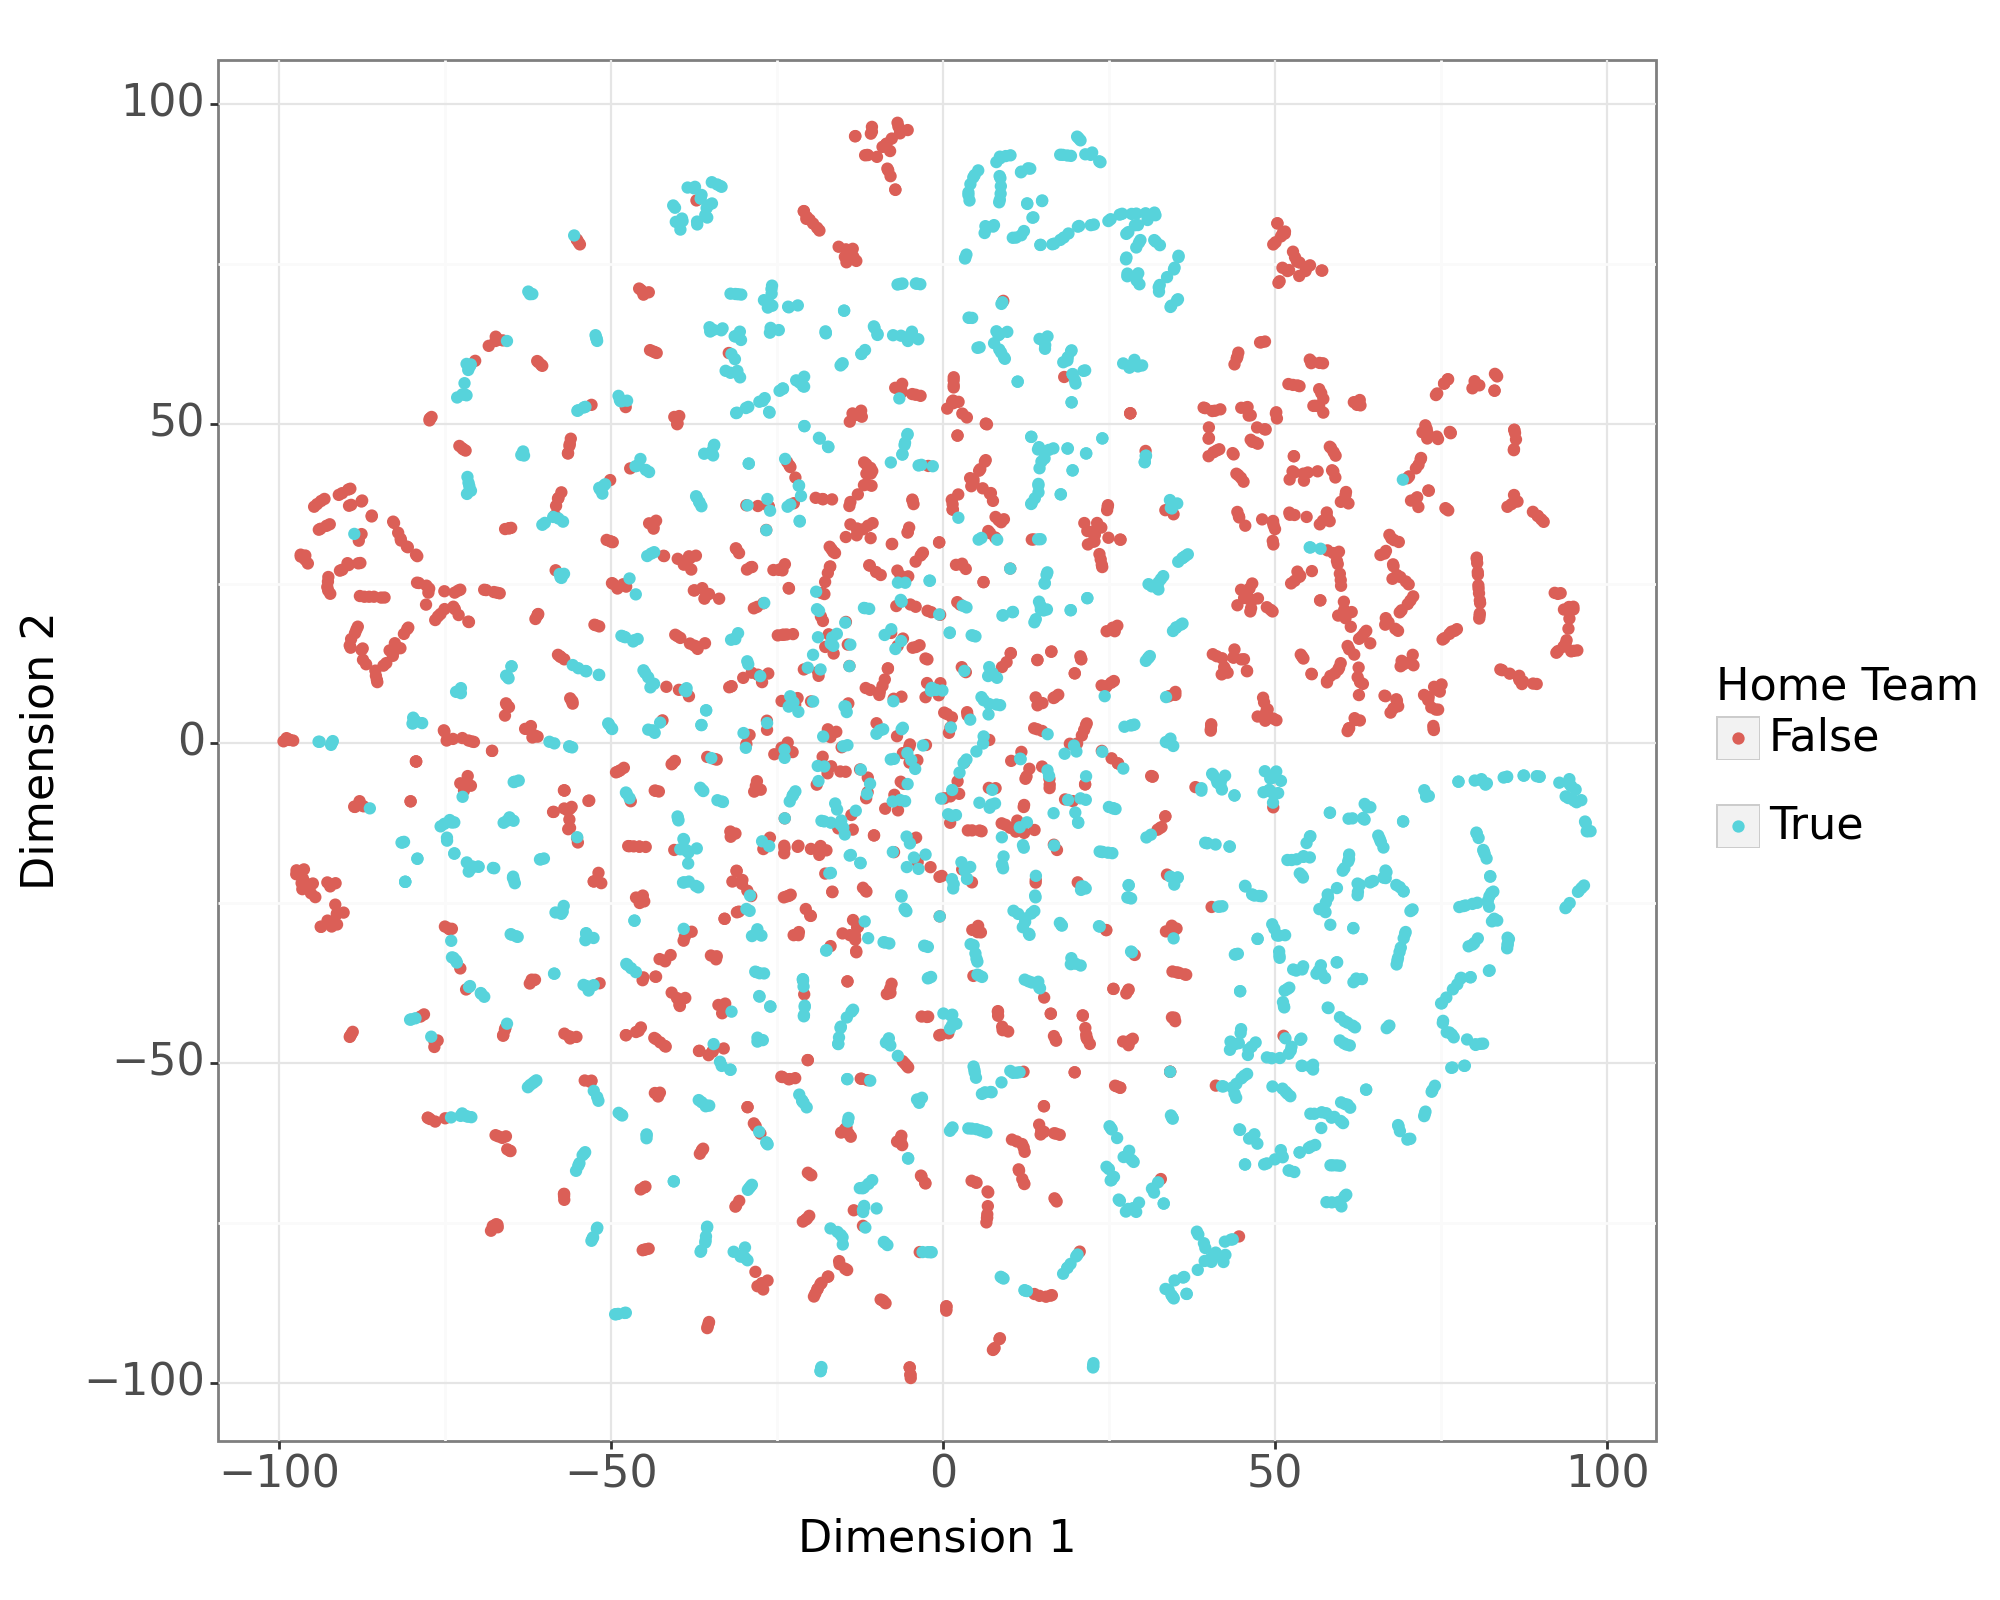

<Figure Size: (1000 x 800)>

In [19]:
(
    tsne_embeddings_df
    .pipe(ggplot, aes(x = 'dim_1', y = 'dim_2', colour = 'team')) +
    geom_point() +
    theme_bw() +
    labs(x = "Dimension 1", y = "Dimension 2", colour = "Home Team") +
    theme(figure_size=(10, 8), text=element_text(size=16), legend_entry_spacing_y=16)
)

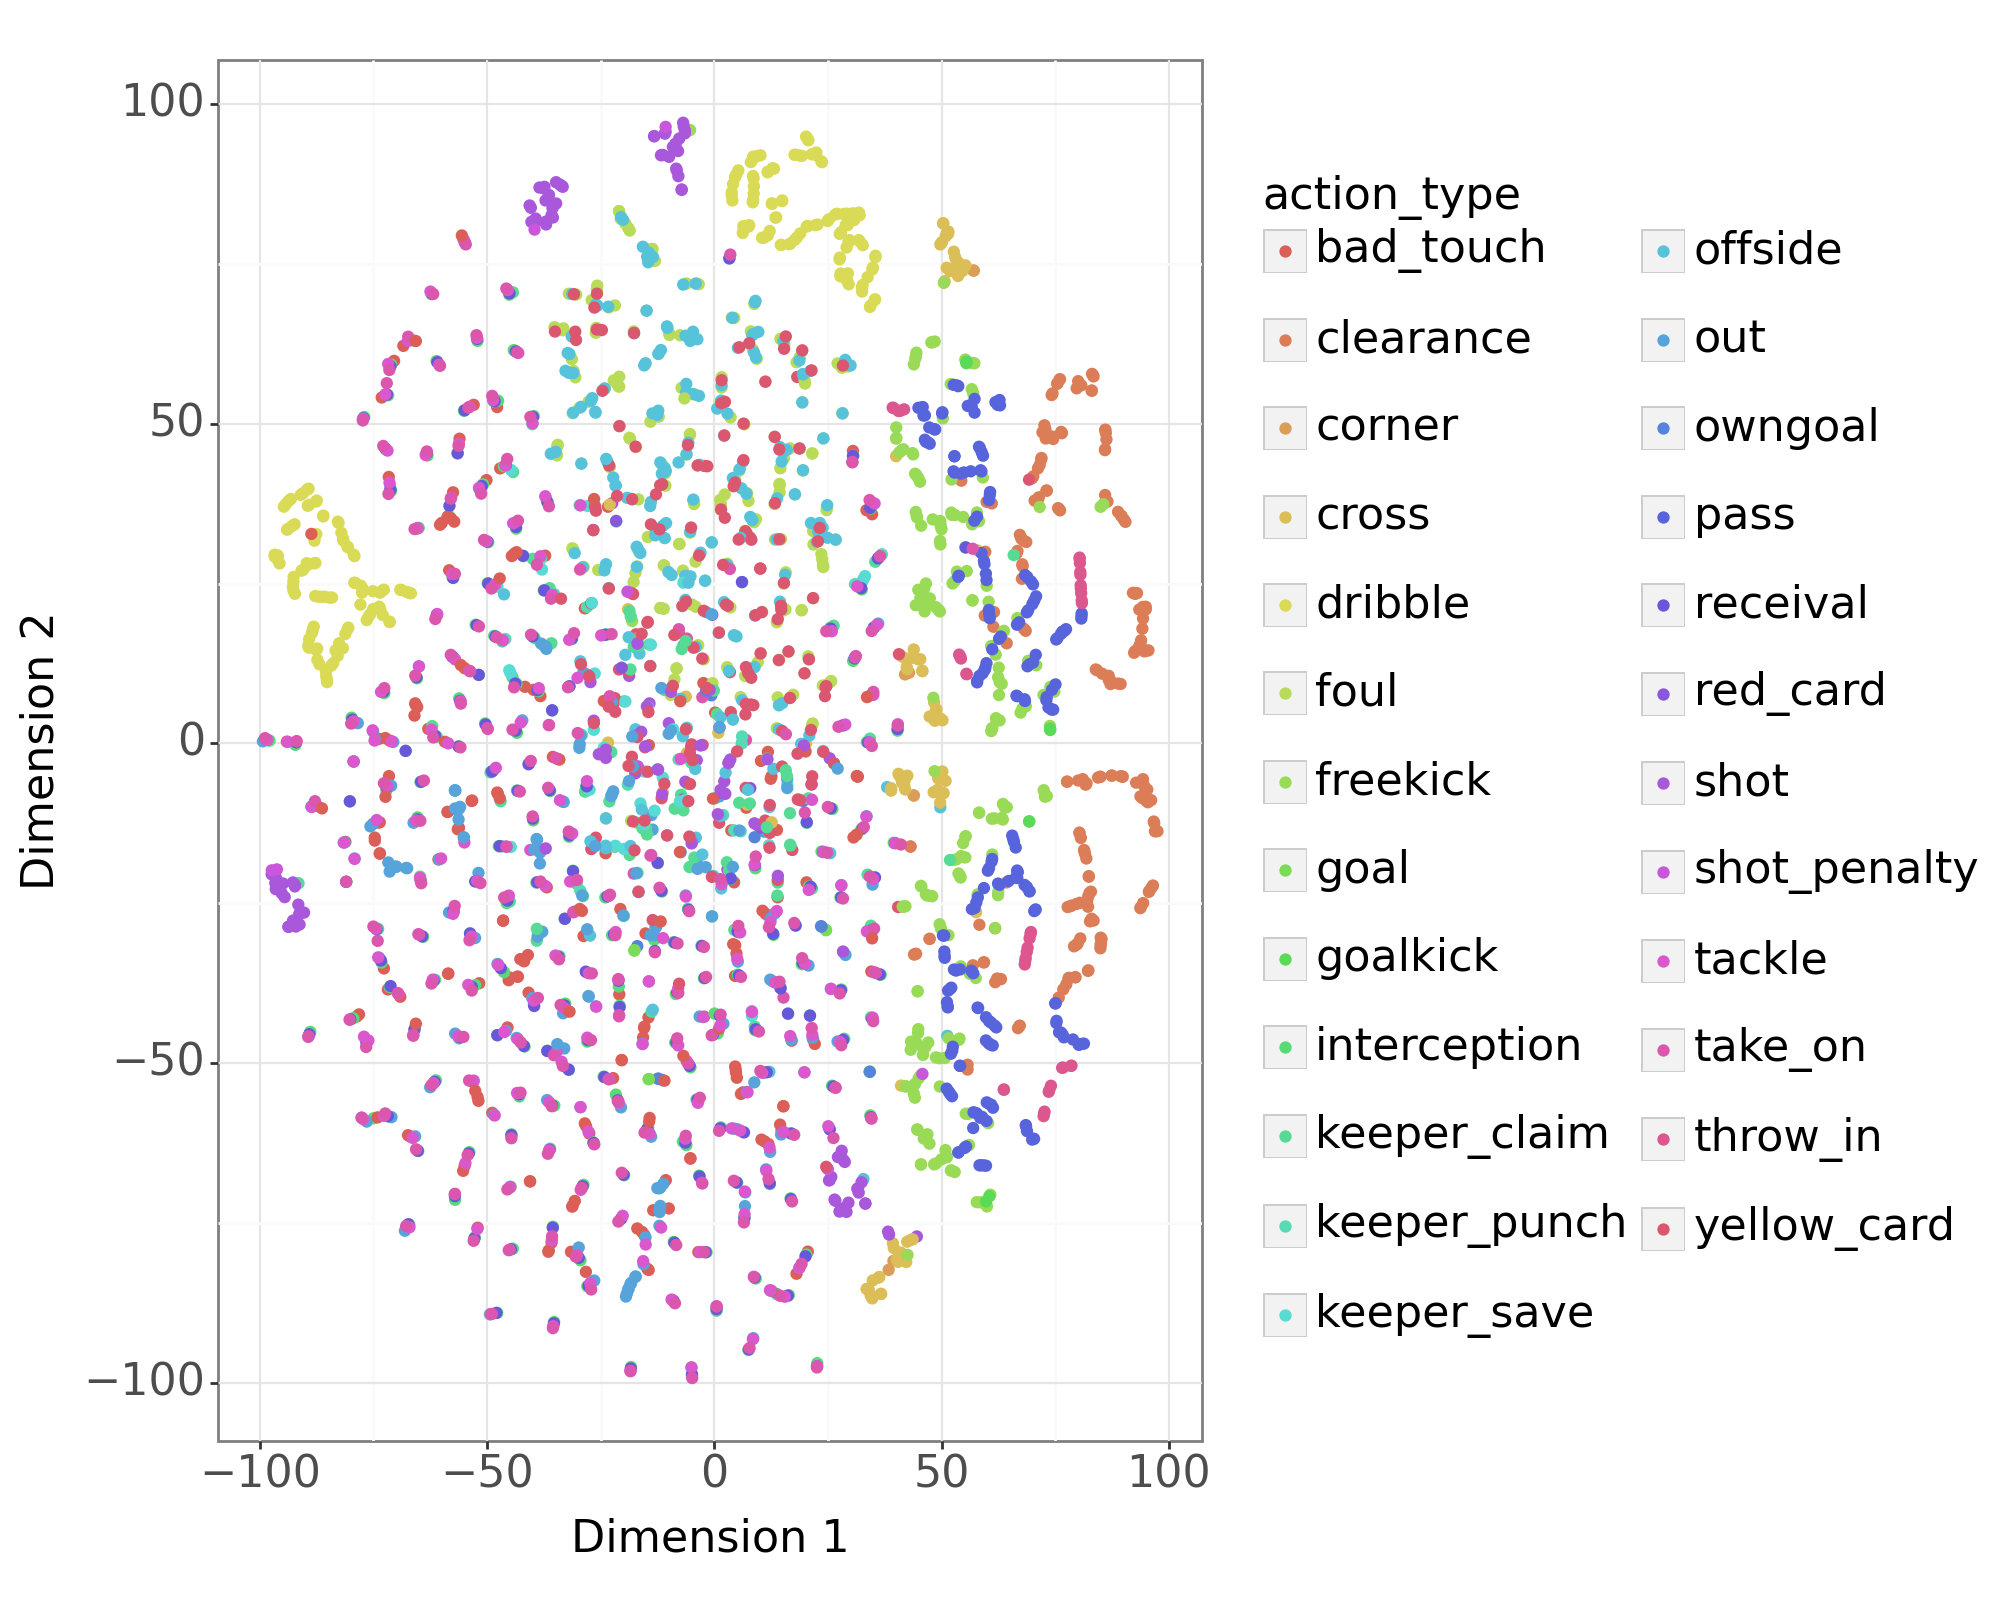

<Figure Size: (1000 x 800)>

In [20]:
(
    tsne_embeddings_df
    .pipe(ggplot, aes(x = 'dim_1', y = 'dim_2', colour = 'action_type')) +
    geom_point() +
    theme_bw() +
    labs(x = "Dimension 1", y = "Dimension 2") +
    theme(figure_size=(10, 8), text=element_text(size=16), legend_entry_spacing_y=16)
)

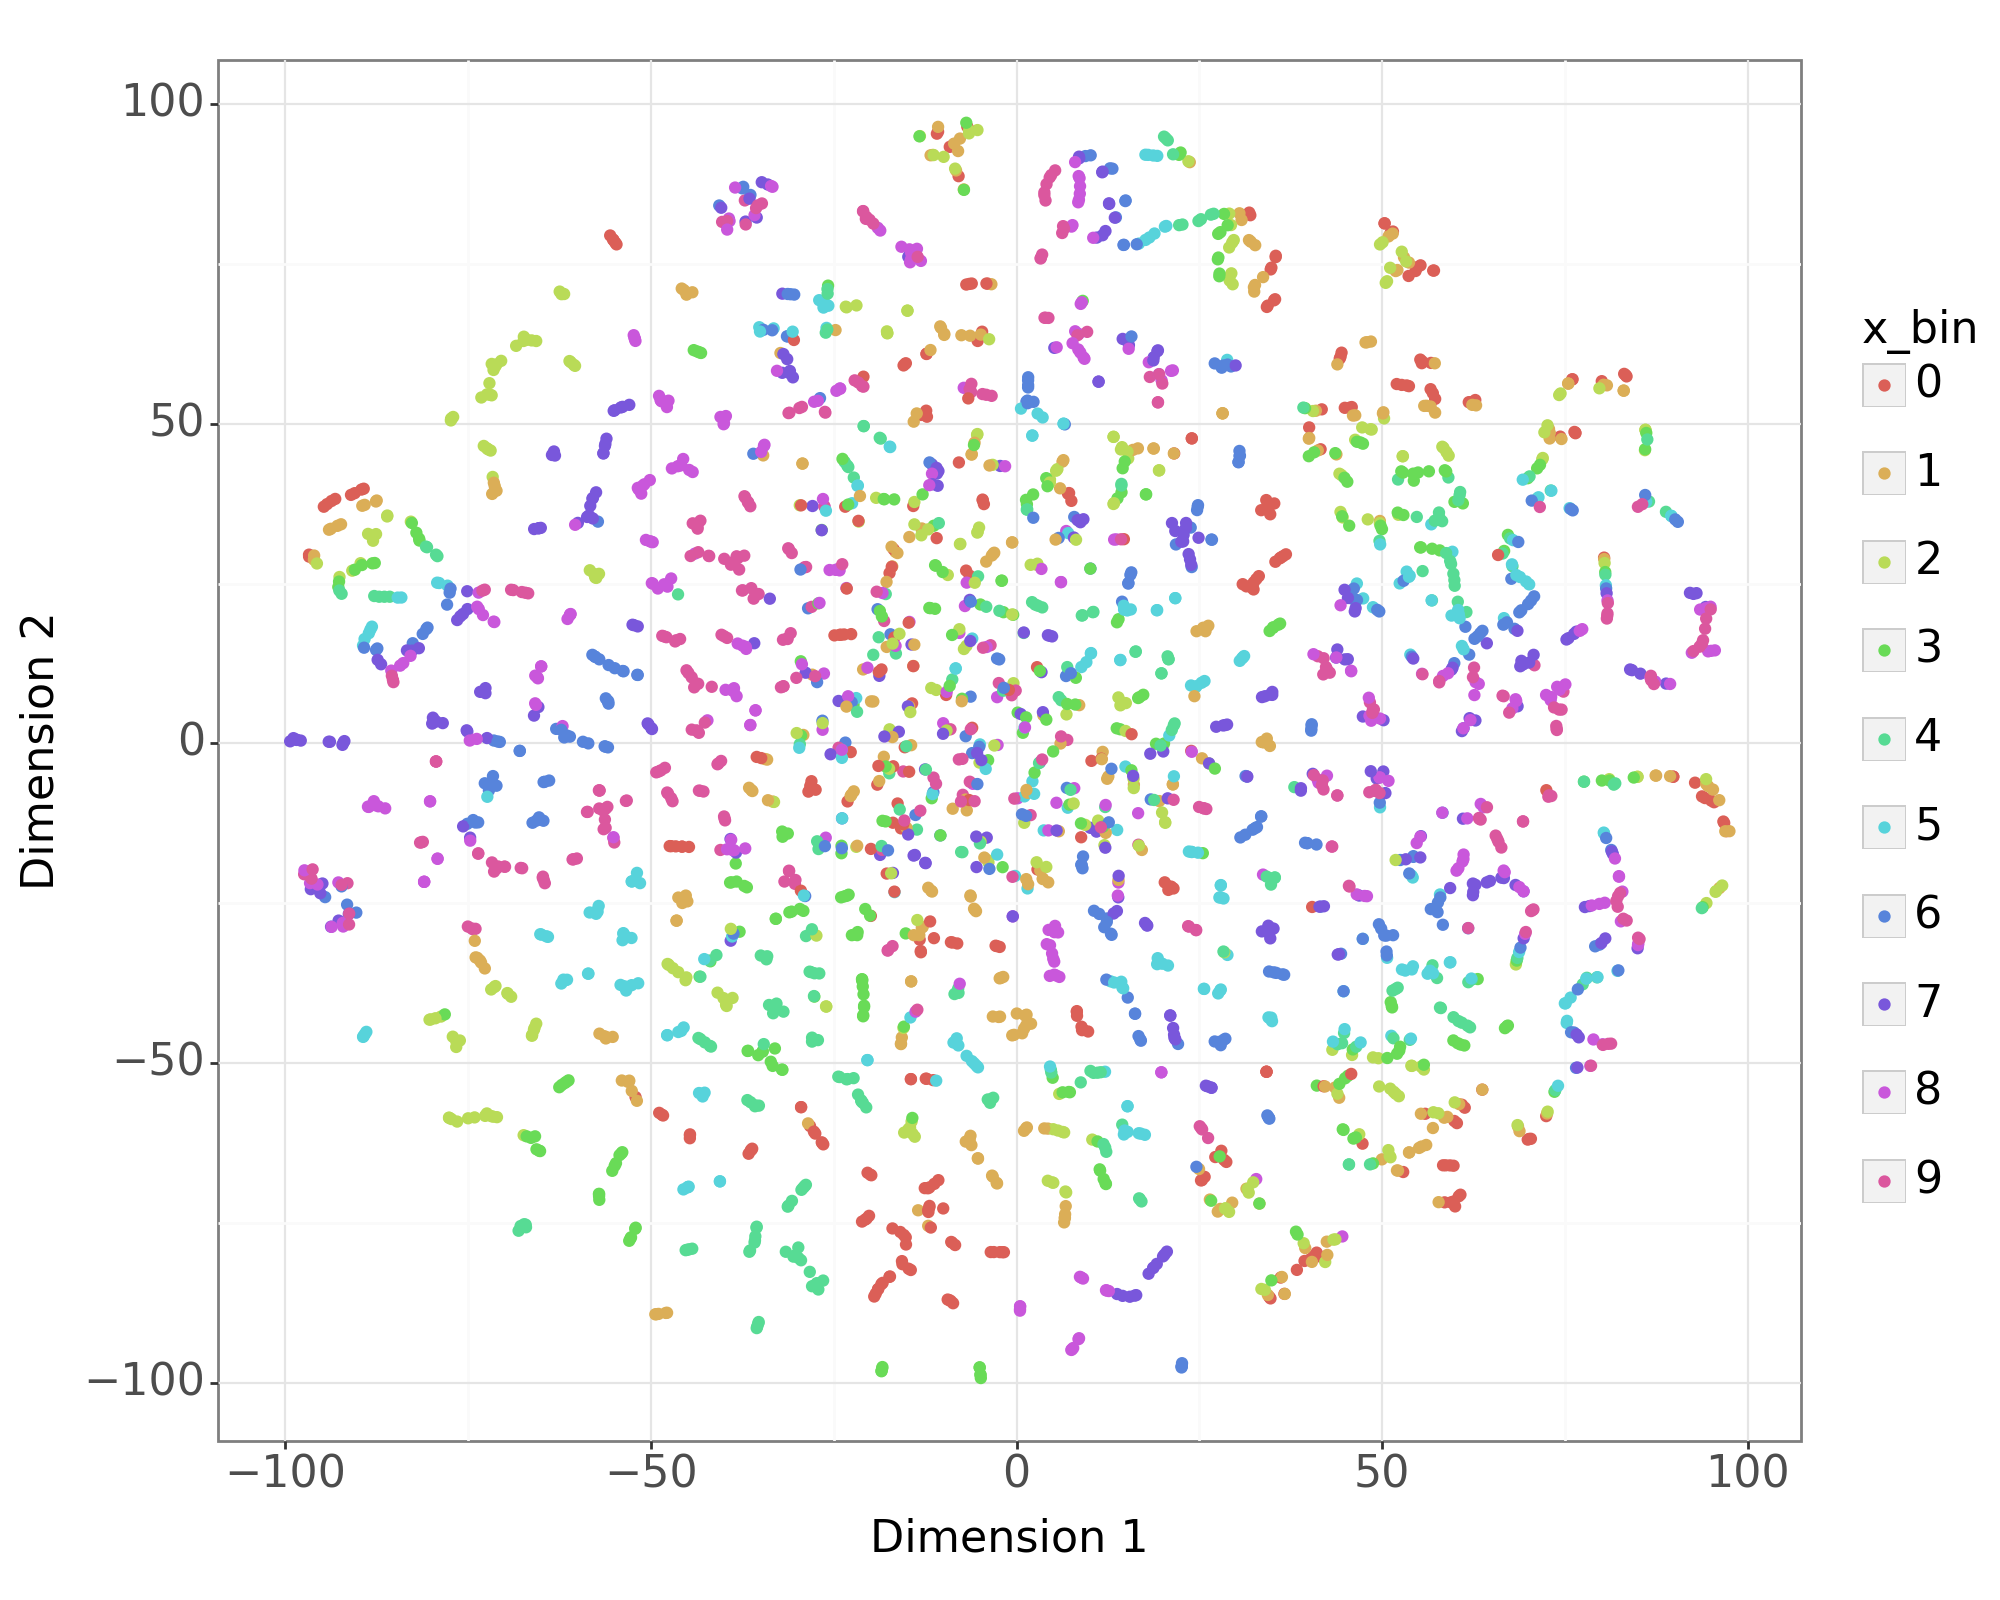

<Figure Size: (1000 x 800)>

In [21]:
(
    tsne_embeddings_df
    .pipe(ggplot, aes(x = 'dim_1', y = 'dim_2', colour = 'x_bin')) +
    geom_point() +
    theme_bw() +
    labs(x = "Dimension 1", y = "Dimension 2") +
    theme(figure_size=(10, 8), text=element_text(size=16), legend_entry_spacing_y=16)
)

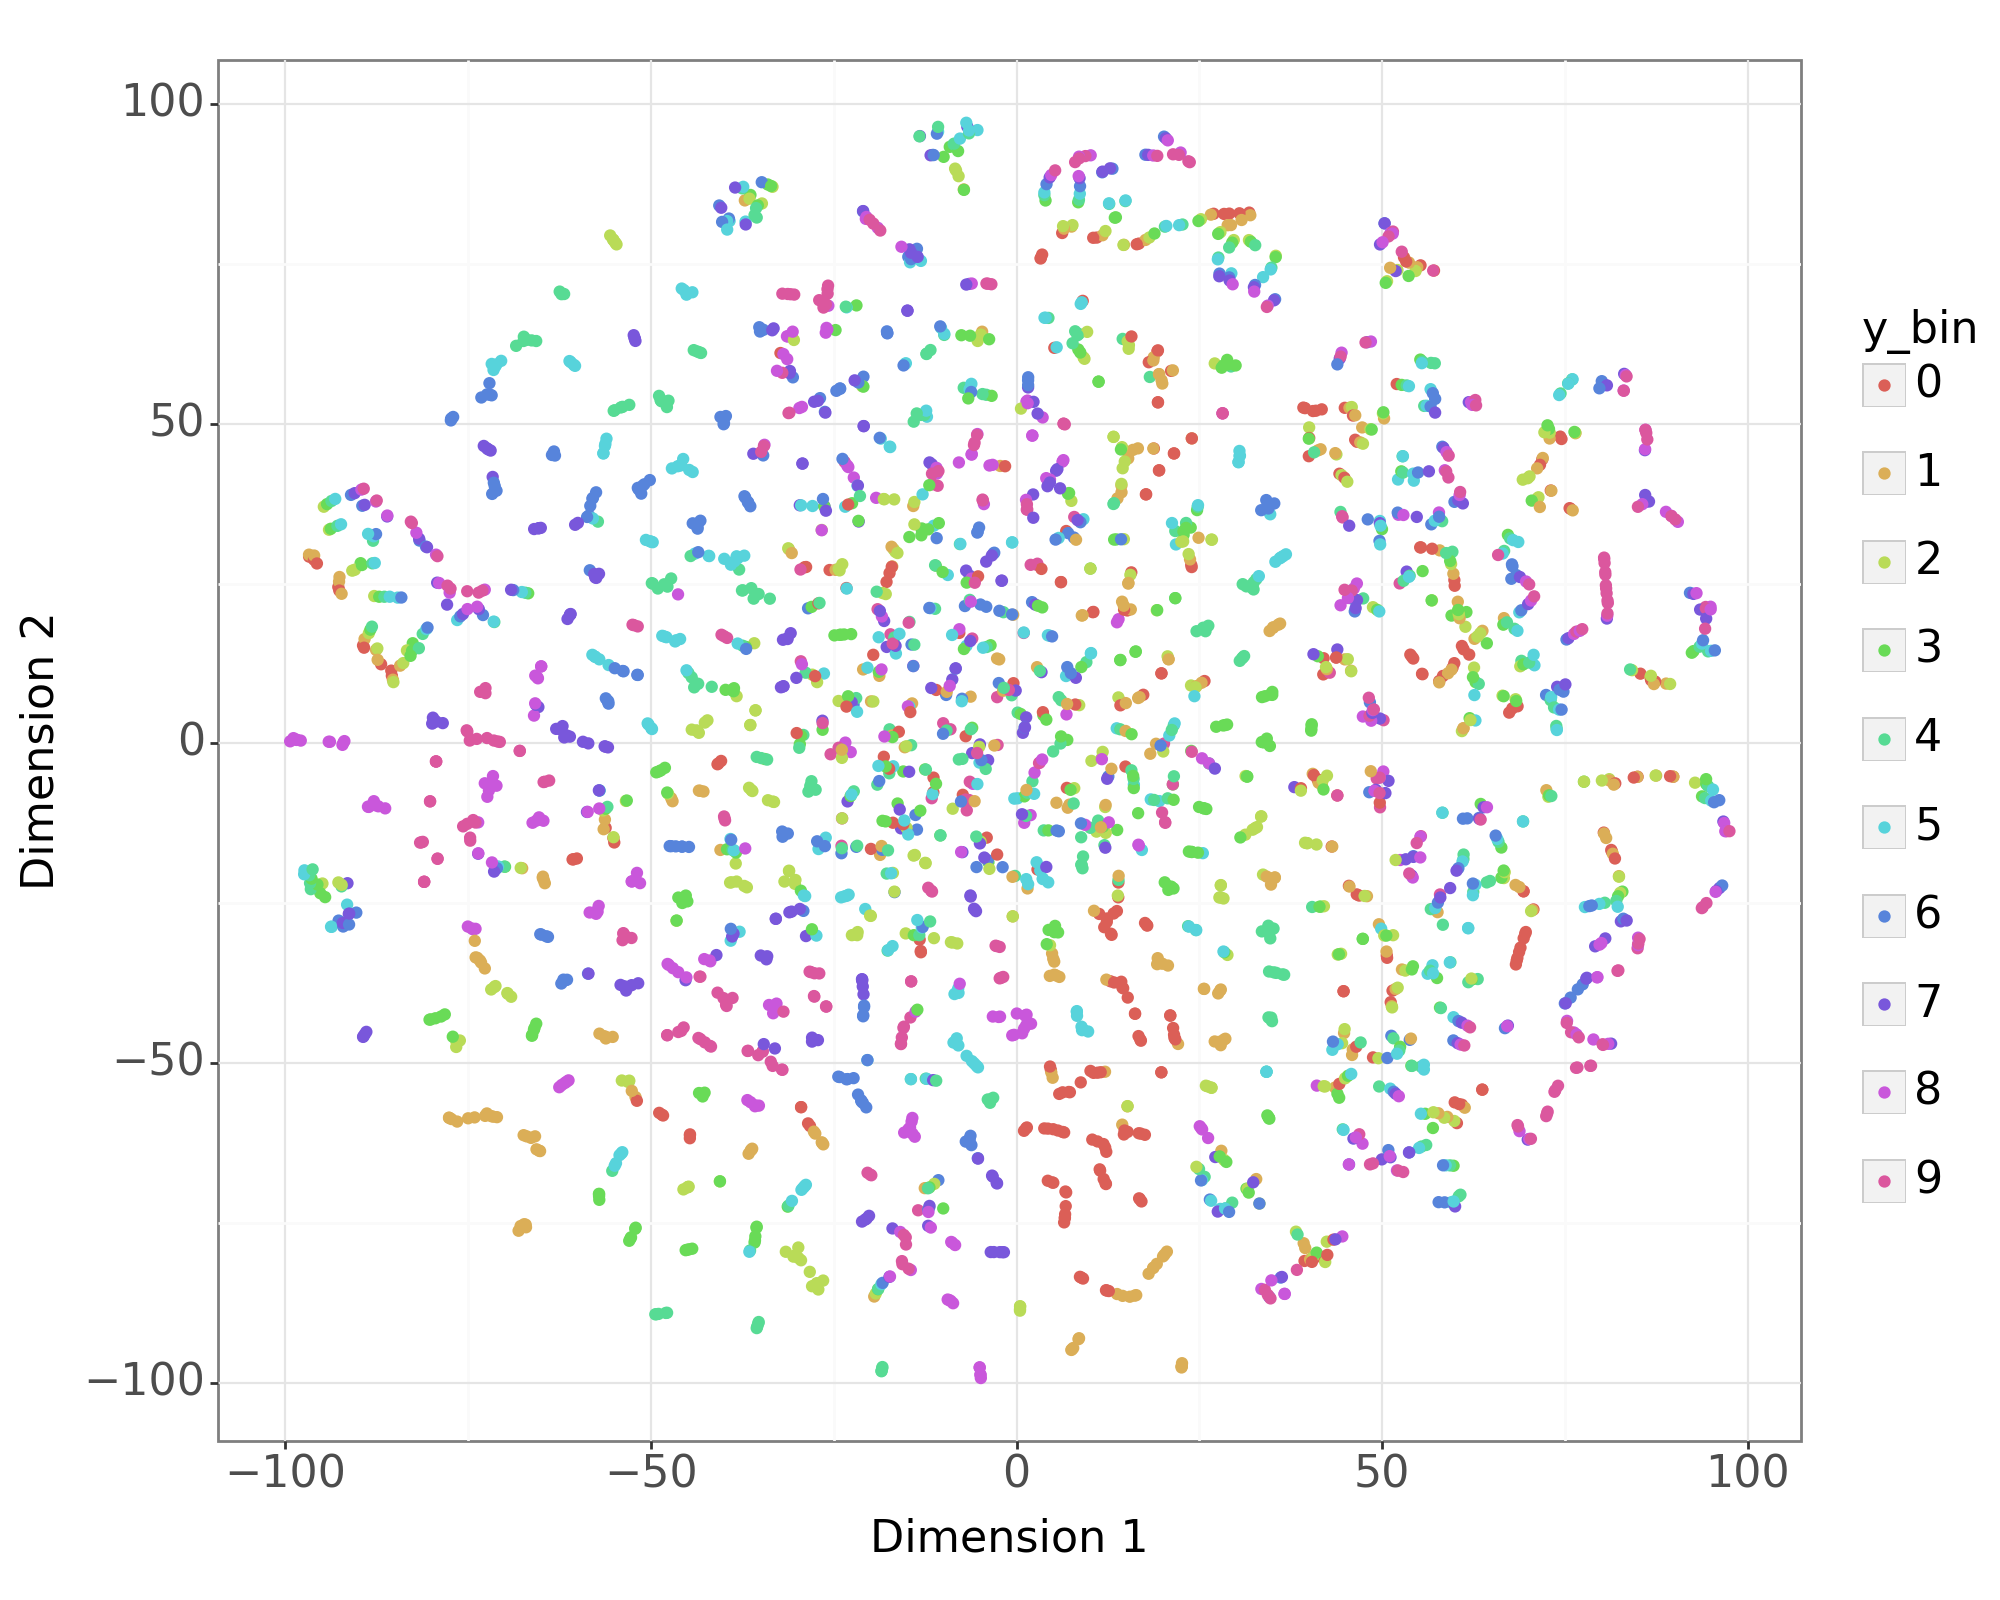

<Figure Size: (1000 x 800)>

In [22]:
(
    tsne_embeddings_df
    .pipe(ggplot, aes(x = 'dim_1', y = 'dim_2', colour = 'y_bin')) +
    geom_point() +
    theme_bw() +
    labs(x = "Dimension 1", y = "Dimension 2") +
    theme(figure_size=(10, 8), text=element_text(size=16), legend_entry_spacing_y=16)
)